# Speaker Recognition with SincNet

### Reference Paper
**Title:** *Speaker Recognition from Raw Waveform with SincNet* (2019)  
**Authors:** Mirco Ravanelli & Yoshua Bengio (MILA)

## 1. Context and Motivation
Traditional speaker recognition systems largely rely on **hand-crafted features** (e.g., FBANK, MFCC) or **i-vector** representations. While robust, these fixed feature extraction methods may inadvertently smooth out or lose narrow-band, high-frequency clues essential for distinguishing speaker identities.

Recent trends have shifted towards **Deep Learning on raw waveforms**, typically using Convolutional Neural Networks (CNNs). Standard CNNs process raw audio using learned Finite Impulse Response (FIR) filters:

$$y[n] = (x \ast h)[n] = \sum_{l=0}^{L-1} x[l] \cdot h[n-l]$$

where $L$ is the filter length and all elements of $h$ are learned parameters.

**The Problem:** The first layer of a standard CNN often struggles with raw audio. It tends to learn noisy, uninterpretable filters, particularly when training data is scarce. This results in high dimensionality and inefficient learning.

## 2. The SincNet Innovation
SincNet introduces a constrained architectural inductive bias. Instead of learning every point in the filter kernel $h$, SincNet defines the first convolution layer as a set of **parametrized band-pass filters**.

### Mathematical Formulation
The core idea is to convolve the waveform with a function $g$ that depends only on a few learnable parameters $\theta$:
$$y[n] = (x \ast g_{\theta})[n]$$

In the **Frequency Domain**, a generic band-pass filter can be defined as the difference between two rectangular functions:
$$G[f, f_1, f_2] = \text{rect}\left(\frac{f}{2f_2}\right) - \text{rect}\left(\frac{f}{2f_1}\right)$$
where $f_1$ and $f_2$ are the learned low and high cutoff frequencies.

By applying the Inverse Fourier Transform, we obtain the filter in the **Time Domain** (using the property that the transform of a rect is a sinc):
$$g[n, f_1, f_2] = 2f_2 \text{sinc}(2\pi f_2 n) - 2f_1 \text{sinc}(2\pi f_1 n)$$
where $\text{sinc}(x) = \sin(x)/x$.

**Key Advantage:** This reduces the number of parameters per filter from $L$ (filter length, e.g., 251) to just **2** ($f_1, f_2$).

## 3. Practical Implementation & Signal Processing Constraints
To make this approach viable in a deep learning framework, several practical engineering constraints are applied:

**A. Parameter Constraints**
To ensure stability and physical meaning ($f_2 \geq f_1 \geq 0$), the network does not learn $f_1, f_2$ directly, but rather auxiliary parameters that are mapped as follows:
* $f_1^{\text{abs}} = |f_1|$
* $f_2^{\text{abs}} = f_1^{\text{abs}} + |f_2 - f_1^{\text{abs}}|$

**B. Windowing**
The theoretical sinc function is infinite. In practice, the filter must be truncated to length $L$. Abrupt truncation causes ripples in the frequency response (Gibbs phenomenon). To mitigate this, a **Hamming window** $w[n]$ is applied:
$$g_w[n, f_1, f_2] = g[n, f_1, f_2] \cdot w[n]$$
$$w[n] = 0.54 - 0.46 \cos\left(\frac{2\pi n}{L}\right)$$

**C. Symmetry**
Since the sinc function and the window are symmetric, the convolution can be computed efficiently by processing one half of the filter and mirroring it.

## 4. Expected Benefits
1.  **Fast Convergence:** By forcing the network to focus only on high-impact parameters (cutoff frequencies), the model converges significantly faster than standard CNNs.
2.  **Parameter Efficiency:** drastic reduction in the first layer's parameter count ($2 \cdot F$ vs $F \cdot L$).
3.  **Interpretability:** The resulting filters are human-readable band-pass filters, allowing direct analysis of which frequency bands the network uses to identify speakers.
4.  **Few-Shot Robustness:** The constraints act as a regularizer, making SincNet highly suitable for regimes with limited training data.

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import librosa
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.effects
from scipy.signal import welch
import scipy.stats
import random
from IPython.display import Audio, display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
from collections import defaultdict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
from sklearn.model_selection import KFold

# EMO-DB : Analyse exploratoire et Prétraitement pour SincNet

In [ ]:
# Mapping des codes d'émotion EMO-DB
EMOTION_MAP = {
    'W': ('anger', 0),
    'L': ('boredom', 1),
    'E': ('disgust', 2),
    'A': ('fear', 3),
    'F': ('happiness', 4),
    'T': ('sadness', 5),
    'N': ('neutral', 6),
}
SAMPLING_RATE = 16000
DATA_DIR = Path('./data')
AUDIO_EXT = '.wav'

## 0. Chargement et parsing des fichiers EMO-DB

- Extraction des métadonnées à partir des noms de fichiers
- Chargement des signaux audio
- Construction d'une structure de données centralisée

In [ ]:
def parse_filename(filename):
    """Parse le nom de fichier pour extraire les métadonnées. Example: 03a01Fa.wav"""
    m = re.match(r'(\d{2})([a-z]\d{2})([A-Z])([a-z]?)\.wav', filename)
    if not m:
        return None
    speaker, text, emotion_code, version = m.groups()
    emotion, emotion_idx = EMOTION_MAP[emotion_code]
    return {
        'filename': filename,
        'speaker_id': speaker,
        'text_id': text,
        'emotion_code': emotion_code,
        'emotion': emotion,
        'emotion_idx': emotion_idx,
        'version': version or None
    }

In [ ]:
# Parcours des fichiers
records = []
for fname in os.listdir(DATA_DIR):
    if fname.endswith(AUDIO_EXT):
        meta = parse_filename(fname)
        if meta:
            meta['filepath'] = str(DATA_DIR / fname)
            records.append(meta)

df = pd.DataFrame(records)
print(f"{len(df)} fichiers chargés.")

535 fichiers chargés.


In [ ]:
df.head(5)

,filename,speaker_id,text_id,emotion_code,emotion,emotion_idx,version,filepath
0,03a01Fa.wav,03,a01,F,happiness,4,a,data\03a01Fa.wav
1,03a01Nc.wav,03,a01,N,neutral,6,c,data\03a01Nc.wav
2,03a01Wa.wav,03,a01,W,anger,0,a,data\03a01Wa.wav
3,03a02Fc.wav,03,a02,F,happiness,4,c,data\03a02Fc.wav
4,03a02Nc.wav,03,a02,N,neutral,6,c,data\03a02Nc.wav


## 1. Analyse exploratoire (EDA)

### 1.1 Distribution des classes d'émotion

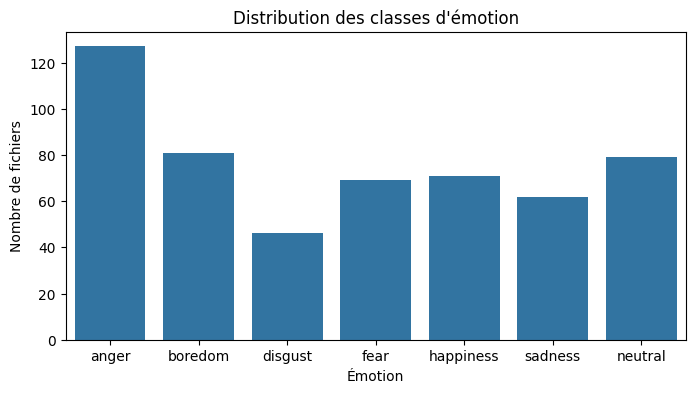

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='emotion', order=[v[0] for v in EMOTION_MAP.values()])
plt.title('Distribution des classes d\'émotion')
plt.ylabel('Nombre de fichiers')
plt.xlabel('Émotion')
plt.show()

### 1.2 Distribution par locuteur et par émotion

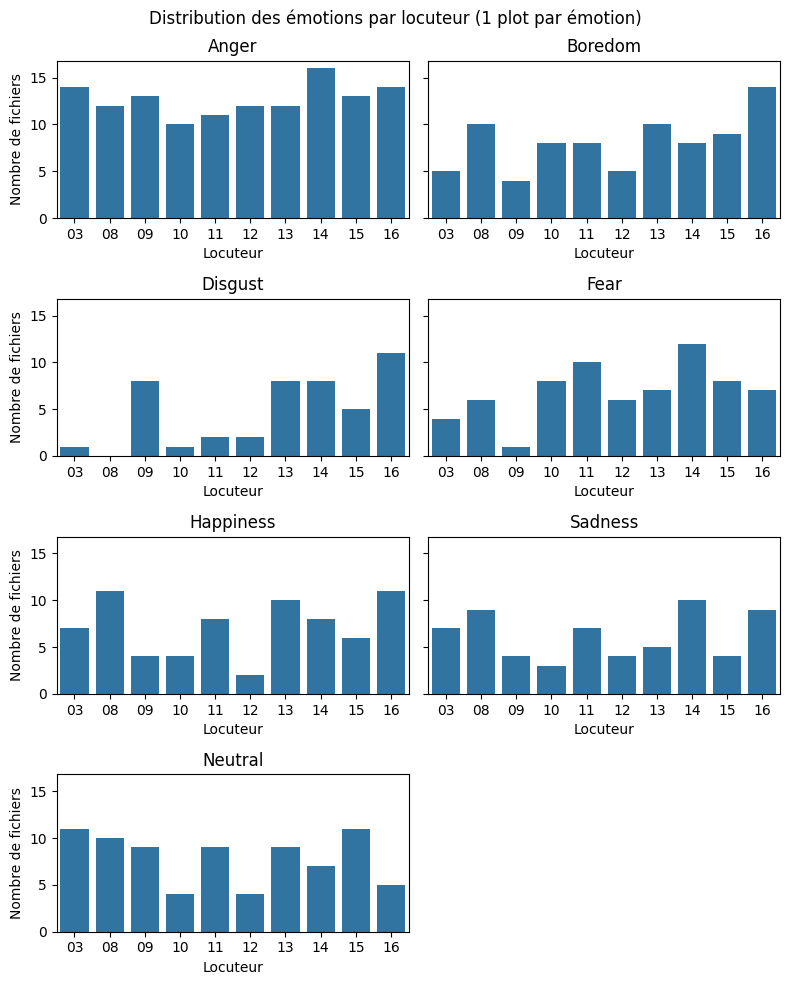

In [ ]:
emotions = [v[0] for v in EMOTION_MAP.values()]
ncols = 2
nrows = int(np.ceil(len(emotions) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 10), sharey=True)
axes = axes.flatten()

for i, emotion in enumerate(emotions):
    ax = axes[i]
    sns.countplot(data=df[df['emotion'] == emotion], x='speaker_id', order=sorted(df['speaker_id'].unique()), ax=ax)
    ax.set_title(emotion.capitalize())
    ax.set_xlabel('Locuteur')
    if i % ncols == 0:
        ax.set_ylabel('Nombre de fichiers')
    else:
        ax.set_ylabel('')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Distribution des émotions par locuteur (1 plot par émotion)")
fig.tight_layout()
plt.show()

### 1.3 Statistiques descriptives audio (durée, énergie, etc.)

In [ ]:
# Calcul des statistiques descriptives pour chaque signal
stats = {
    'mean': [],
    'median': [],
    'std': [],
    'min': [],
    'max': [],
    'skewness': [],
    'q25': [],
    'q75': [],
    'kurtosis': []
}

for fp in tqdm(df['filepath'], desc="Calcul des statistiques"): 
    y, sr = librosa.load(fp, sr=SAMPLING_RATE)
    y, _ = librosa.effects.trim(y, top_db=15)
    stats['mean'].append(np.mean(y))
    stats['std'].append(np.std(y))
    stats['min'].append(np.min(y))
    stats['max'].append(np.max(y))
    stats['q25'].append(np.percentile(y, 25))
    stats['median'].append(np.median(y))
    stats['q75'].append(np.percentile(y, 75))
    stats['skewness'].append(scipy.stats.skew(y))
    stats['kurtosis'].append(scipy.stats.kurtosis(y))

for k, v in stats.items():
    df[k] = v

Calcul des statistiques: 100%|██████████| 535/535 [00:08<00:00, 60.15it/s]


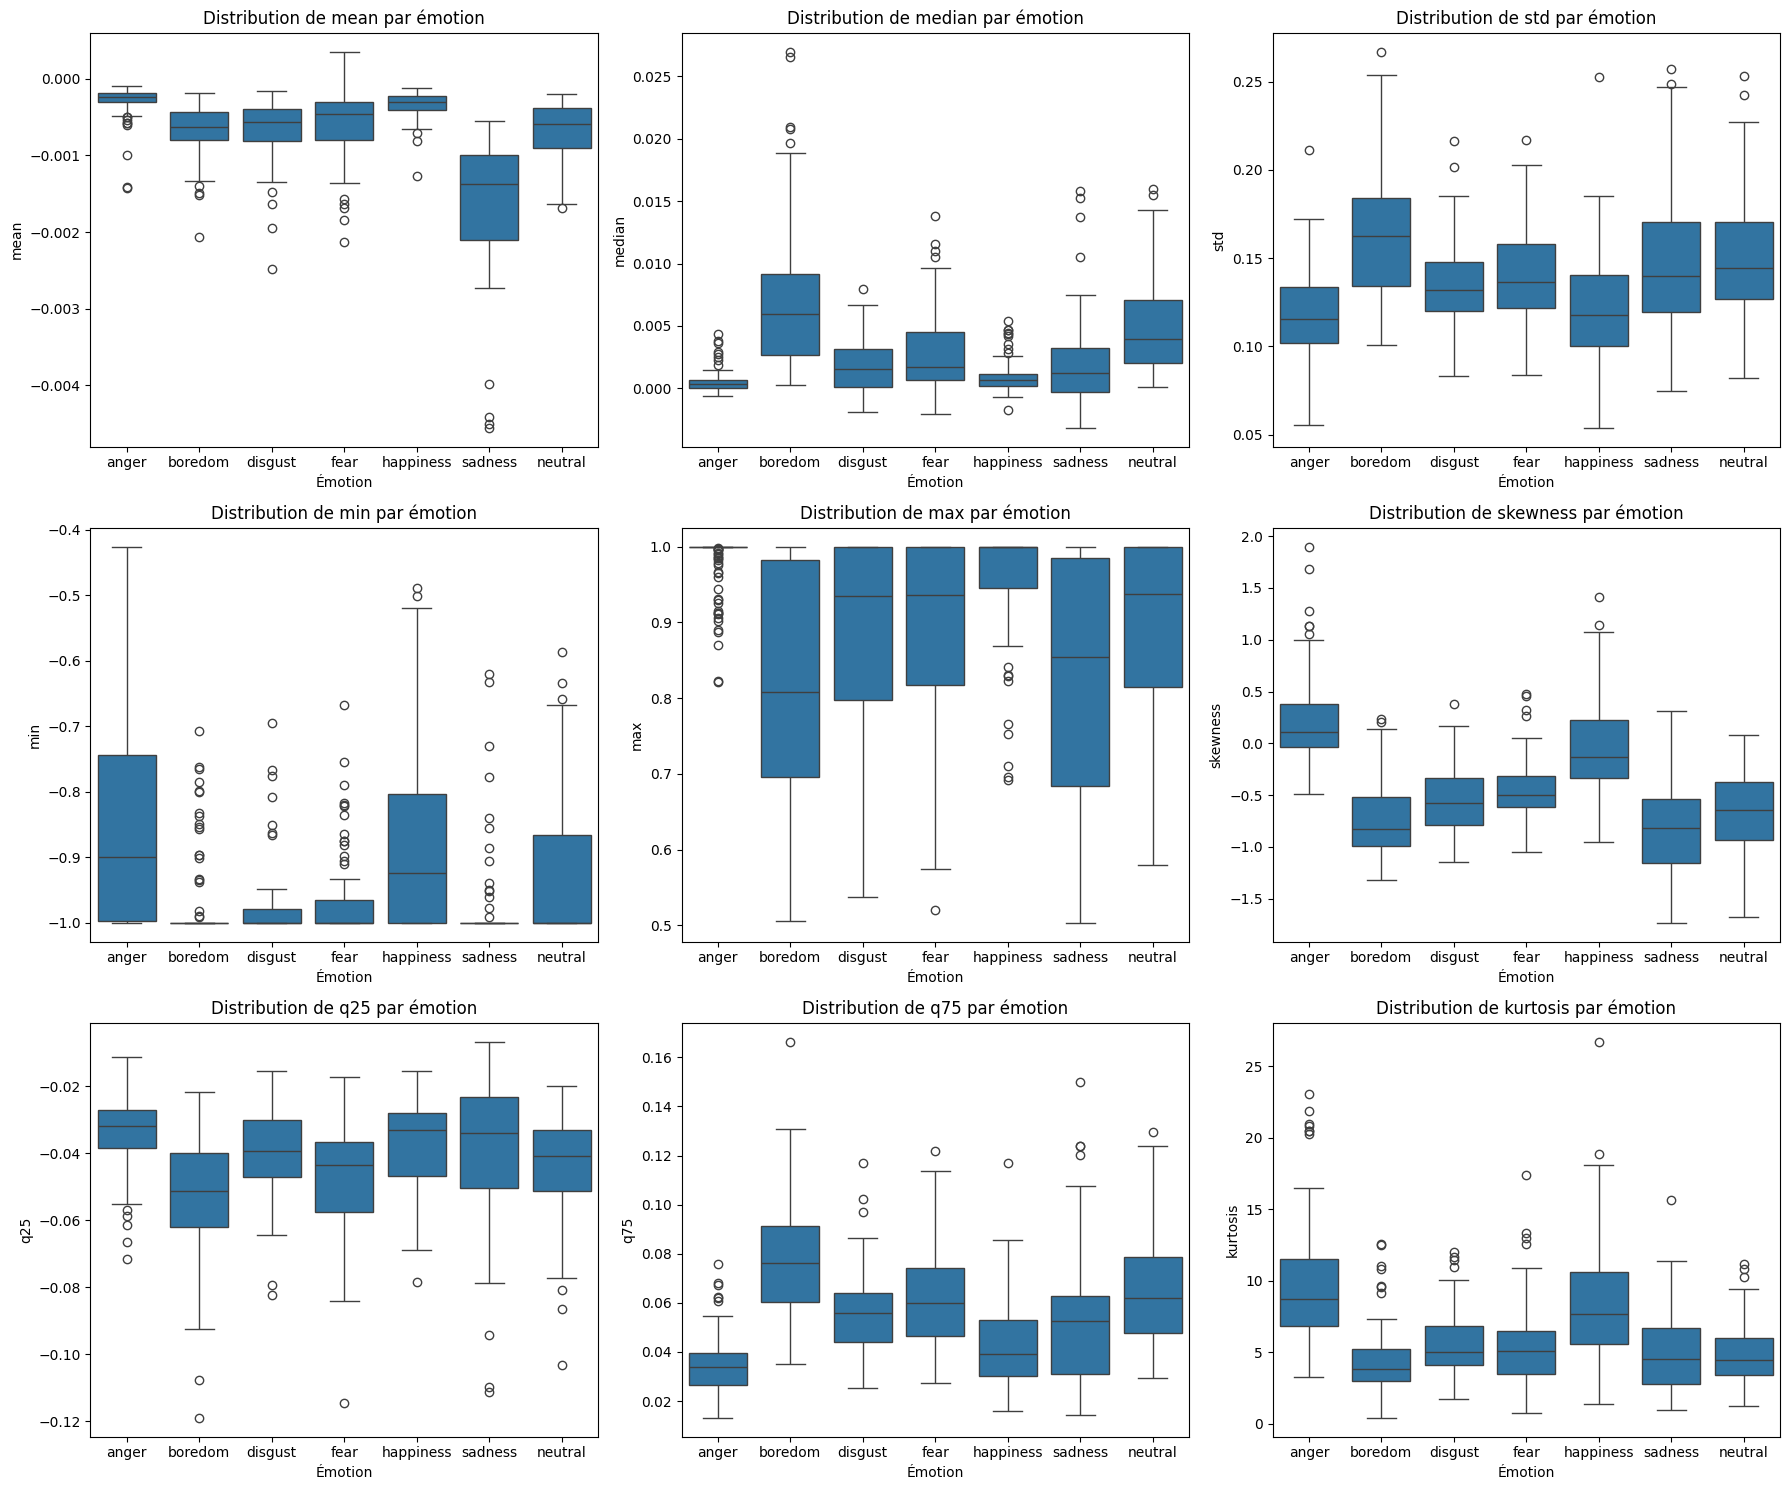

In [ ]:
stat_names = stats.keys()
n_stats = len(stat_names)
ncols = 3
nrows = int(np.ceil(n_stats / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))

for i, stat in enumerate(stat_names):
    ax = axes.flatten()[i]
    sns.boxplot(data=df, x='emotion', y=stat, order=[v[0] for v in EMOTION_MAP.values()], ax=ax)
    ax.set_title(f'Distribution de {stat} par émotion')
    ax.set_xlabel('Émotion')
    ax.set_ylabel(stat)

for j in range(i+1, nrows*ncols):
    axes.flatten()[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Calculer la durée et l'énergie de chaque signal
durations = []
energies = []

for fp in df['filepath']:
    y, sr = librosa.load(fp, sr=SAMPLING_RATE)
    y, _ = librosa.effects.trim(y, top_db=15)
    durations.append(len(y)/sr)
    energies.append(np.sqrt(np.mean(y**2)))

df['duration_sec'] = durations
df['energy'] = energies

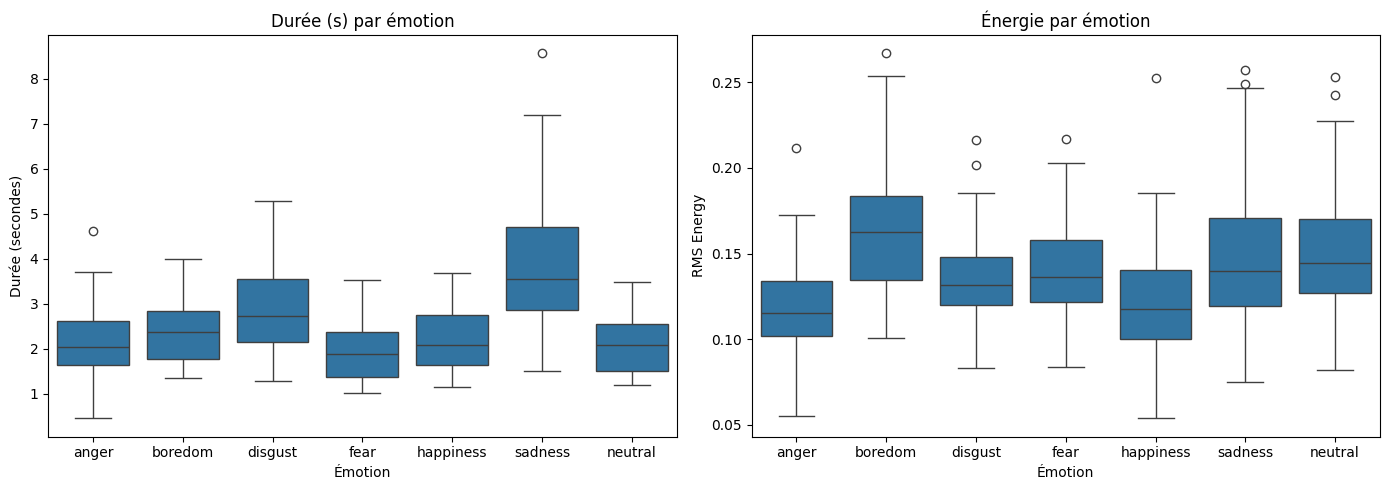

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x='emotion', y='duration_sec', order=[v[0] for v in EMOTION_MAP.values()], ax=axes[0])
axes[0].set_title("Durée (s) par émotion")
axes[0].set_xlabel("Émotion")
axes[0].set_ylabel("Durée (secondes)")

sns.boxplot(data=df, x='emotion', y='energy', order=[v[0] for v in EMOTION_MAP.values()], ax=axes[1])
axes[1].set_title("Énergie par émotion")
axes[1].set_xlabel("Émotion")
axes[1].set_ylabel("RMS Energy")

plt.tight_layout()
plt.show()

## 2. Visualisation de signaux et spectrogrammes

On compare la même phrase prononcée avec différentes émotions.

In [ ]:
emotions = [v[0] for v in EMOTION_MAP.values()]
group_counts = df.groupby(['text_id', 'speaker_id', 'emotion']).size().unstack(fill_value=0)
valid_pairs = group_counts[(group_counts > 0).all(axis=1)].index.tolist()

random.seed(13)
text_id, speaker_id = random.choice(valid_pairs)
print(f"text_id sélectionné : {text_id} | locuteur : {speaker_id}")
extraits = (
    df[(df['text_id'] == text_id) & (df['speaker_id'] == speaker_id)]
    .groupby('emotion')
    .apply(lambda g: g.sample(1, random_state=13))
    .reset_index(drop=True)
)
for _, row in extraits.iterrows():
    print(f"Émotion: {row['emotion']} | Fichier: {row['filename']}")
    display(Audio(filename=row['filepath'], rate=SAMPLING_RATE))

text_id sélectionné : a04 | locuteur : 16
Émotion: anger | Fichier: 16a04Wc.wav


C:\Users\perni\AppData\Local\Temp\ipykernel_15148\687437168.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(1, random_state=13))


Émotion: boredom | Fichier: 16a04Lc.wav


Émotion: disgust | Fichier: 16a04Ea.wav


Émotion: fear | Fichier: 16a04Ab.wav


Émotion: happiness | Fichier: 16a04Fa.wav


Émotion: neutral | Fichier: 16a04Nc.wav


Émotion: sadness | Fichier: 16a04Tc.wav


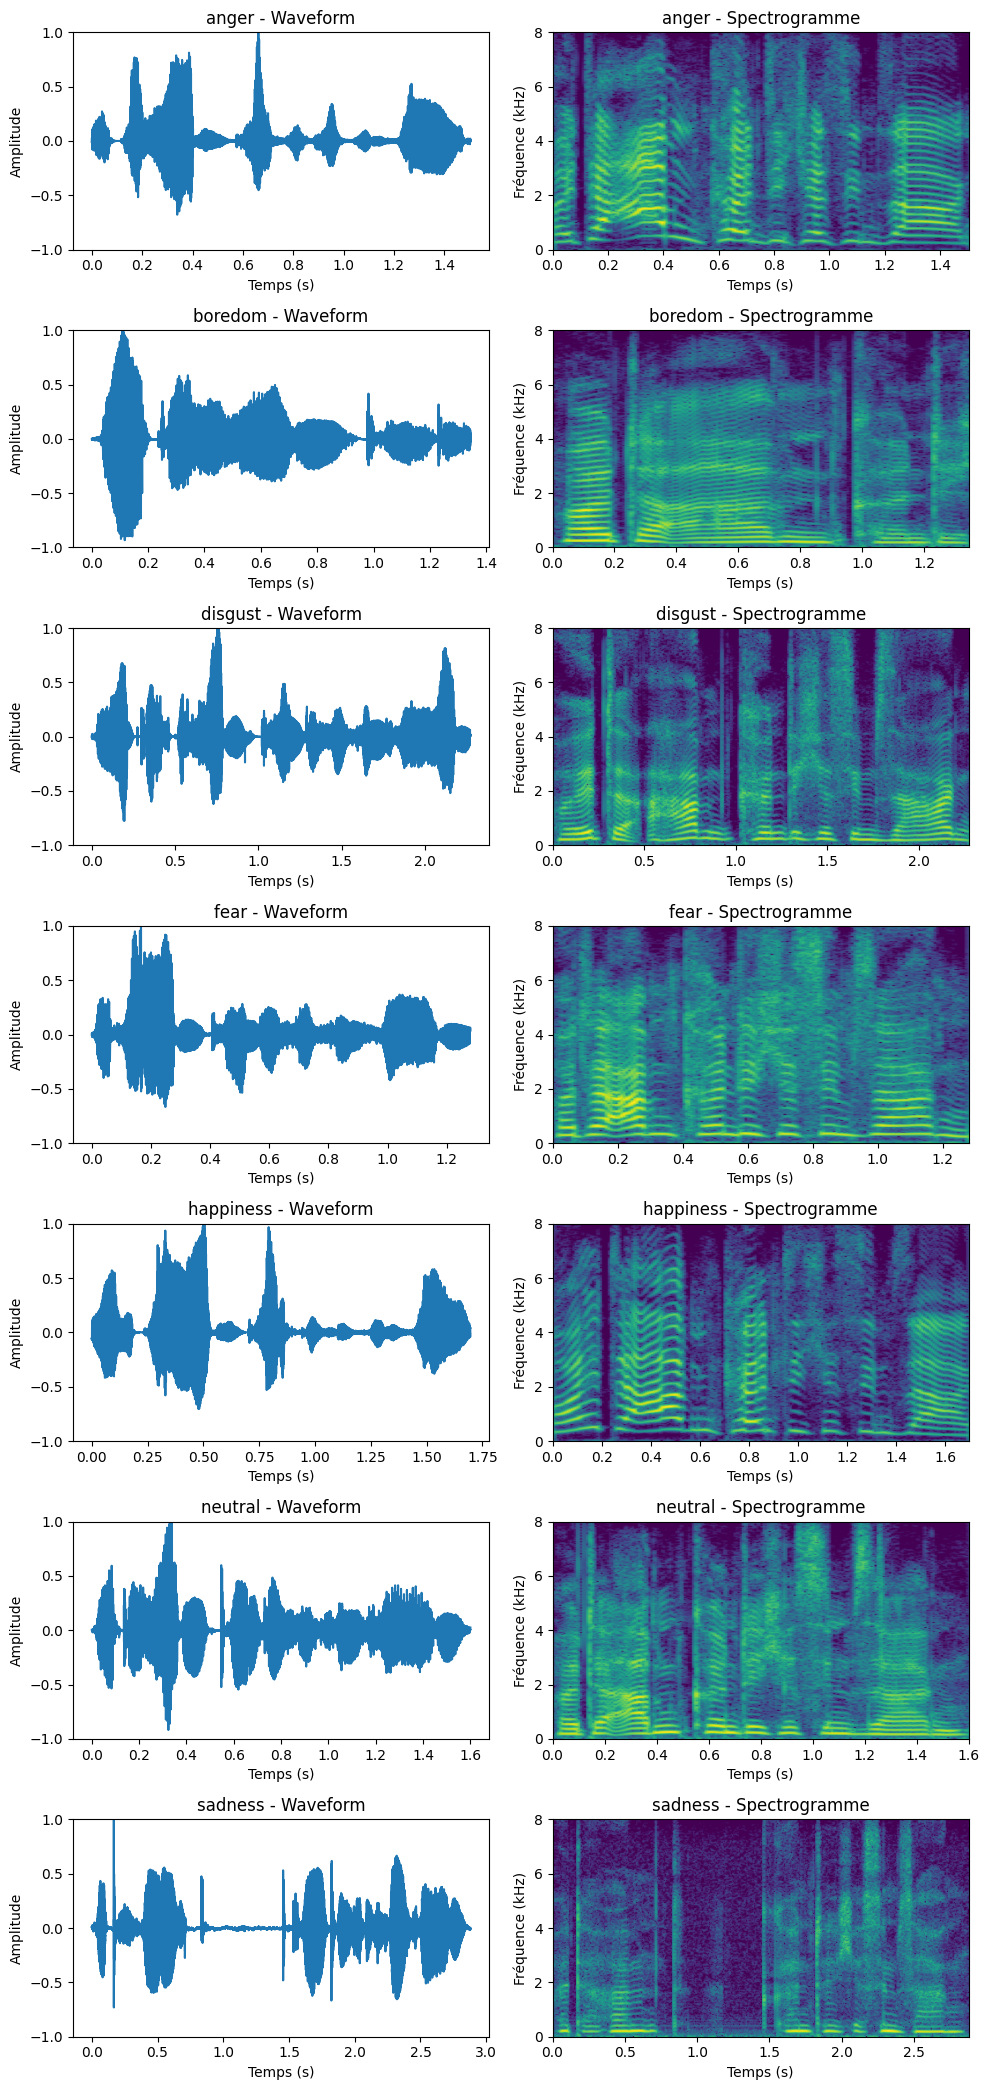

In [ ]:
fig, axes = plt.subplots(len(extraits), 2, figsize=(10, 3*len(extraits)))
for i, row in extraits.iterrows():
    y, sr = librosa.load(row['filepath'], sr=SAMPLING_RATE)
    y, _ = librosa.effects.trim(y, top_db=15)
    y = y / np.max(np.abs(y))
    # Waveform
    axes[i,0].plot(np.arange(len(y))/sr, y)
    axes[i,0].set_title(f"{row['emotion']} - Waveform")
    axes[i,0].set_ylabel('Amplitude')
    axes[i,0].set_xlabel('Temps (s)')
    axes[i,0].set_ylim([-1, 1])
    # Spectrogramme
    S = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=512)), ref=np.max)
    img = axes[i,1].imshow(S, aspect='auto', origin='lower', extent=[0, len(y)/sr, 0, sr/2/1000])
    axes[i,1].set_title(f"{row['emotion']} - Spectrogramme")
    axes[i,1].set_ylabel('Fréquence (kHz)')
    axes[i,1].set_xlabel('Temps (s)')
fig.tight_layout()
plt.show()

## 3. Analyse de la durée après suppression des silences

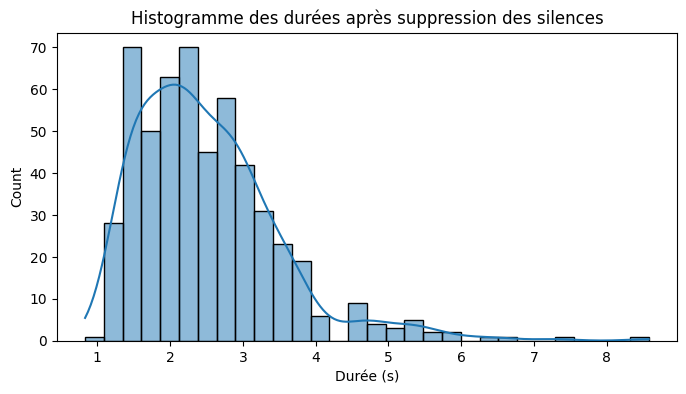

In [ ]:
trimmed_durations = []
for fp in df['filepath']:
    y, sr = librosa.load(fp, sr=SAMPLING_RATE)
    y_trim, _ = librosa.effects.trim(y, top_db=20)
    trimmed_durations.append(len(y_trim)/sr)
df['trimmed_duration_sec'] = trimmed_durations

plt.figure(figsize=(8,4))
sns.histplot(df['trimmed_duration_sec'], bins=30, kde=True)
plt.title('Histogramme des durées après suppression des silences')
plt.xlabel('Durée (s)')
plt.show()

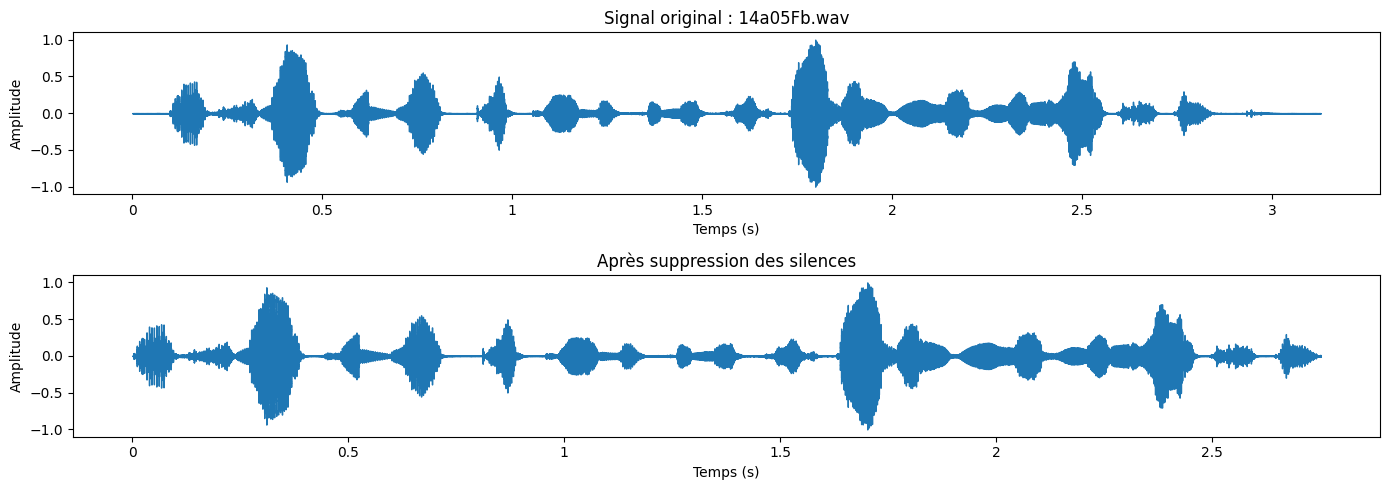

In [ ]:
row = df.sample(1, random_state=1).iloc[0]
y, sr = librosa.load(row['filepath'], sr=SAMPLING_RATE)
y_trim, _ = librosa.effects.trim(y, top_db=15)

plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title(f"Signal original : {row['filename']}")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_trim, sr=sr)
plt.title("Après suppression des silences")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [ ]:
print("Audio original :")
display(Audio(y, rate=sr))
print("Audio après suppression des silences :")
display(Audio(y_trim, rate=sr))

Audio original :


Audio après suppression des silences :


## 4. Densité Spectrale de Puissance (PSD) moyenne par émotion

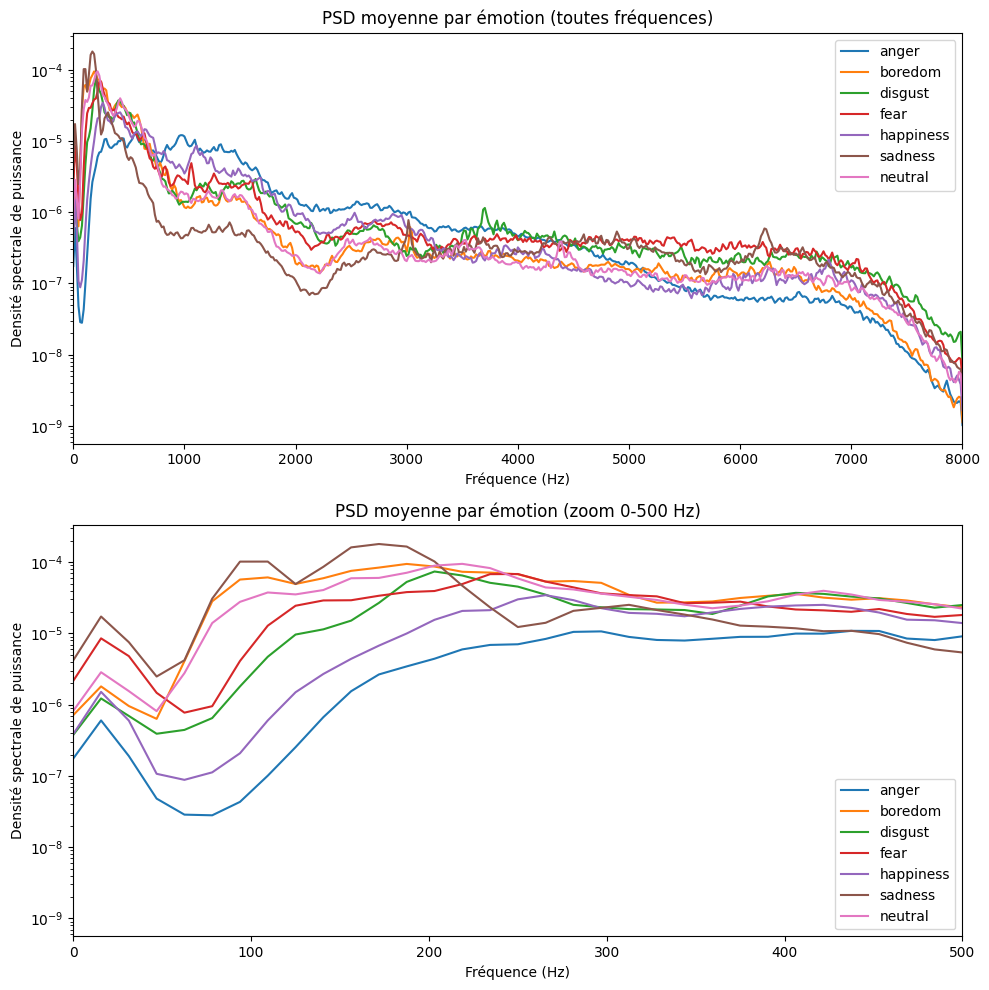

In [ ]:
psd_dict = {emo[0]: [] for emo in EMOTION_MAP.values()}
for _, row in df.iterrows():
    y, sr = librosa.load(row['filepath'], sr=SAMPLING_RATE)
    y_trim, _ = librosa.effects.trim(y, top_db=15)
    f, Pxx = welch(y_trim, fs=sr, nperseg=1024)
    psd_dict[row['emotion']].append(Pxx)

# PSD moyenne par émotion (global + zoom [0, 500] Hz)
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# Graphe global
for emo, (label, _) in EMOTION_MAP.items():
    if len(psd_dict[label]) == 0:
        continue
    mean_psd = np.mean(psd_dict[label], axis=0)
    axes[0].semilogy(f, mean_psd, label=label)
axes[0].set_title('PSD moyenne par émotion (toutes fréquences)')
axes[0].set_xlabel('Fréquence (Hz)')
axes[0].set_ylabel('Densité spectrale de puissance')
axes[0].legend()
axes[0].set_xlim([0, np.max(f)])

# Graphe zoomé
for emo, (label, _) in EMOTION_MAP.items():
    if len(psd_dict[label]) == 0:
        continue
    mean_psd = np.mean(psd_dict[label], axis=0)
    axes[1].semilogy(f, mean_psd, label=label)
axes[1].set_title('PSD moyenne par émotion (zoom 0-500 Hz)')
axes[1].set_xlabel('Fréquence (Hz)')
axes[1].set_ylabel('Densité spectrale de puissance')
axes[1].set_xlim([0, 500])
axes[1].legend()

plt.tight_layout()
plt.show()

# EMO-DB : Baseline ML pour la détection d'émotion

Ce notebook construit un pipeline ML classique (SVM, RandomForest, XGBoost) pour la classification d'émotions à partir de features extraites des signaux audio.

In [ ]:
# Split speaker-independant
train_speakers = ['03', '08', '09', '10', '11', '12', '13', '15', '16']
test_speakers = ['14']

In [ ]:
# Extraction des features à partir des fichiers audio
records = []
for fname in tqdm(os.listdir(DATA_DIR), desc='Extraction features'):
    if fname.endswith(AUDIO_EXT):
        meta = parse_filename(fname)
        if meta:
            # Load audio
            fp = str(DATA_DIR / fname)
            y, sr = librosa.load(fp, sr=SAMPLING_RATE)

            # Trim silence
            y_trim, _ = librosa.effects.trim(y, top_db=15)

            # Compute statistical features
            features = {
                'mean': np.mean(y_trim),
                'median': np.median(y_trim),
                'std': np.std(y_trim),
                'min': np.min(y_trim),
                'max': np.max(y_trim),
                'skewness': scipy.stats.skew(y_trim),
                'q25': np.percentile(y_trim, 25),
                'q75': np.percentile(y_trim, 75),
                'kurtosis': scipy.stats.kurtosis(y_trim),
                'duration_sec': len(y)/sr,
                'energy': np.sqrt(np.mean(y_trim**2)),
            }

            # Prosodiques
            f0, voiced_flag, voiced_probs = librosa.pyin(y_trim, fmin=50, fmax=500, sr=sr)
            f0_mean = np.nanmean(f0)
            f0_std = np.nanstd(f0)

            # Taux de passage par zéro
            zcr = np.mean(librosa.feature.zero_crossing_rate(y_trim))

            # Énergie RMS
            rms = np.mean(librosa.feature.rms(y=y_trim))

            # Spectrales
            mfccs = librosa.feature.mfcc(y=y_trim, sr=sr, n_mfcc=13)
            mfccs_mean = np.mean(mfccs, axis=1)
            mfccs_std = np.std(mfccs, axis=1)
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y_trim, sr=sr))
            spectral_flux = np.mean(np.diff(librosa.feature.spectral_centroid(y=y_trim, sr=sr)))
            spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y_trim, sr=sr, roll_percent=0.85))

            # Ajout aux features
            features.update(
                {
                    'f0_mean': f0_mean,
                    'f0_std': f0_std,
                    'zcr': zcr,
                    'rms': rms,
                    'spectral_centroid': spectral_centroid,
                    'spectral_flux': spectral_flux,
                    'spectral_rolloff': spectral_rolloff
                }
            )
            for i in range(len(mfccs_mean)):
                features[f'mfcc_{i+1}_mean'] = mfccs_mean[i]
                features[f'mfcc_{i+1}_std'] = mfccs_std[i]

            meta.update(features)
            meta['filepath'] = fp
            # Attribution split
            if meta['speaker_id'] in train_speakers:
                meta['split'] = 'train'
            elif meta['speaker_id'] in test_speakers:
                meta['split'] = 'test'
            else:
                meta['split'] = 'unused'
            records.append(meta)

Extraction features:  28%|██▊       | 150/535 [01:31<03:04,  2.09it/s]C:\Users\perni\AppData\Local\Temp\ipykernel_1324\1480755753.py:31: RuntimeWarning: Mean of empty slice
  f0_mean = np.nanmean(f0)
c:\Users\perni\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Extraction features: 100%|██████████| 535/535 [04:41<00:00,  1.90it/s]


In [ ]:
df = pd.DataFrame(records).fillna(0)
df = df[df['split'].isin(['train', 'test'])].copy()

In [ ]:
# Features à utiliser
stat_features = ['mean', 'median', 'std', 'min', 'max', 'skewness', 'q25', 'q75', 'kurtosis', 'duration_sec', 'energy']
signal_features = ['f0_mean', 'f0_std', 'zcr', 'rms', 'spectral_centroid', 'spectral_flux', 'spectral_rolloff'] + \
    [f'mfcc_{i+1}_mean' for i in range(13)] + [f'mfcc_{i+1}_std' for i in range(13)]
all_features = stat_features + signal_features

# Encodage de la cible
le = LabelEncoder()
df['emotion_label'] = le.fit_transform(df['emotion'])
print('Classes:', le.classes_)

Classes: ['anger' 'boredom' 'disgust' 'fear' 'happiness' 'neutral' 'sadness']


## 2. Préprocessing et split train/test

In [ ]:
# Séparation train/test speaker-independent
X_train = df[df['split']=='train'][all_features].values
y_train = df[df['split']=='train']['emotion_label'].values
X_test = df[df['split']=='test'][all_features].values
y_test = df[df['split']=='test']['emotion_label'].values

# Standardisation
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Grid Search et comparaison des modèles

In [ ]:
models = {
    'SVM': (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto'],
        'class_weight': [None, 'balanced'],
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20],
        #'min_samples_split': [2, 5],
        'class_weight': [None, 'balanced'],
        'min_samples_leaf': [1, 2, 4]
    }),
    'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.1, 0.3],
        #'subsample': [0.7, 1.0],
        #'colsample_bytree': [0.7, 1.0],
        #'reg_lambda': [0, 0.1, 1.0],
        'reg_alpha': [1.0, 2.0]
    })
}

In [ ]:
results = {}
scoring_metric = 'f1_macro'

for name, (model, param_grid) in models.items():
    print(f'\n{name}...')
    clf = GridSearchCV(model, param_grid, cv=3, scoring=scoring_metric)

    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred, average='macro')
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f'Best params: {clf.best_params_}')
    print(f'Accuracy: {acc:.3f}')
    print(f'F1 Score (macro): {f1_score_value:.3f}')
    print(f'Balanced Accuracy: {balanced_acc:.3f}')
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    results[name] = {
        'model': clf,
        'y_pred': y_pred,
        'acc': acc,
        'f1_score': f1_score_value,
        'balanced_acc': balanced_acc
    }


SVM...
Best params: {'C': 1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.739
F1 Score (macro): 0.701
Balanced Accuracy: 0.702
              precision    recall  f1-score   support

       anger       0.75      0.94      0.83        16
     boredom       0.57      1.00      0.73         8
     disgust       0.86      0.75      0.80         8
        fear       0.75      0.75      0.75        12
   happiness       0.40      0.25      0.31         8
     neutral       1.00      0.43      0.60         7
     sadness       1.00      0.80      0.89        10

    accuracy                           0.74        69
   macro avg       0.76      0.70      0.70        69
weighted avg       0.76      0.74      0.73        69


RandomForest...
Best params: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Accuracy: 0.739
F1 Score (macro): 0.690
Balanced Accuracy: 0.694
              precision    recall  f1-score   support

       anger

## 4. Matrices de confusion

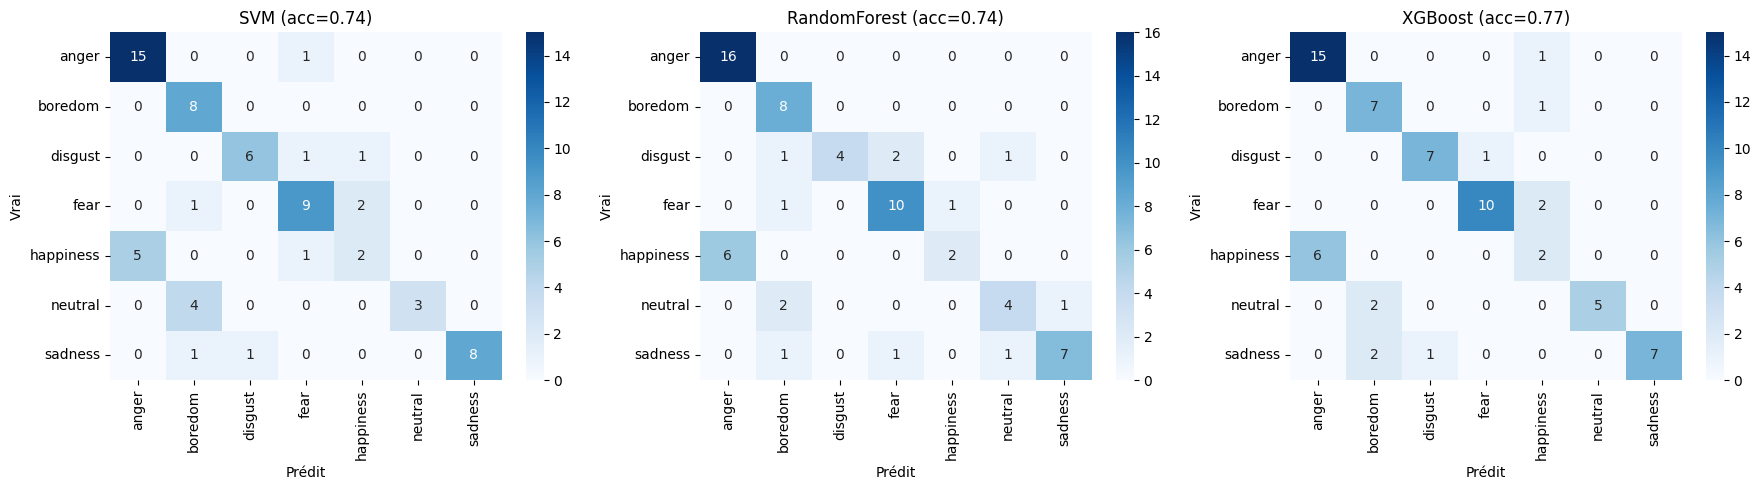

In [ ]:
fig, axes = plt.subplots(1, len(results), figsize=(6*len(results), 5))
if len(results) == 1: axes = [axes]
for ax, (name, res) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=le.classes_, yticklabels=le.classes_)
    ax.set_title(f'{name} (acc={res["acc"]:.2f})')
    ax.set_xlabel('Prédit')
    ax.set_ylabel('Vrai')
plt.tight_layout()
plt.show()

## 5. Analyse des features importantes (RandomForest/XGBoost)

In [ ]:
len(all_features)

44

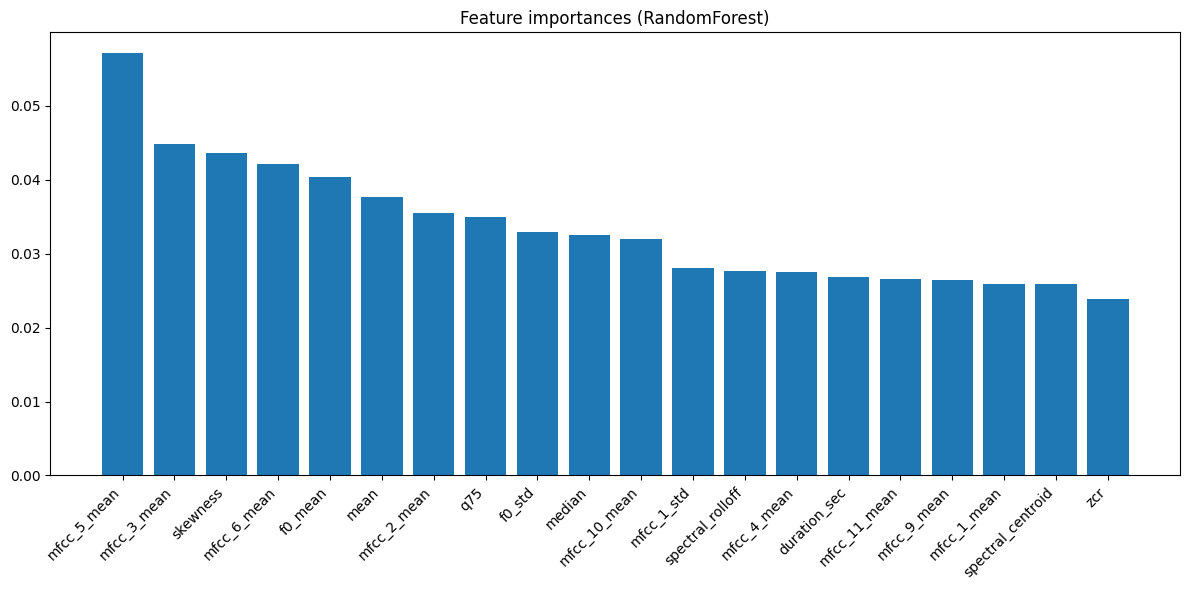

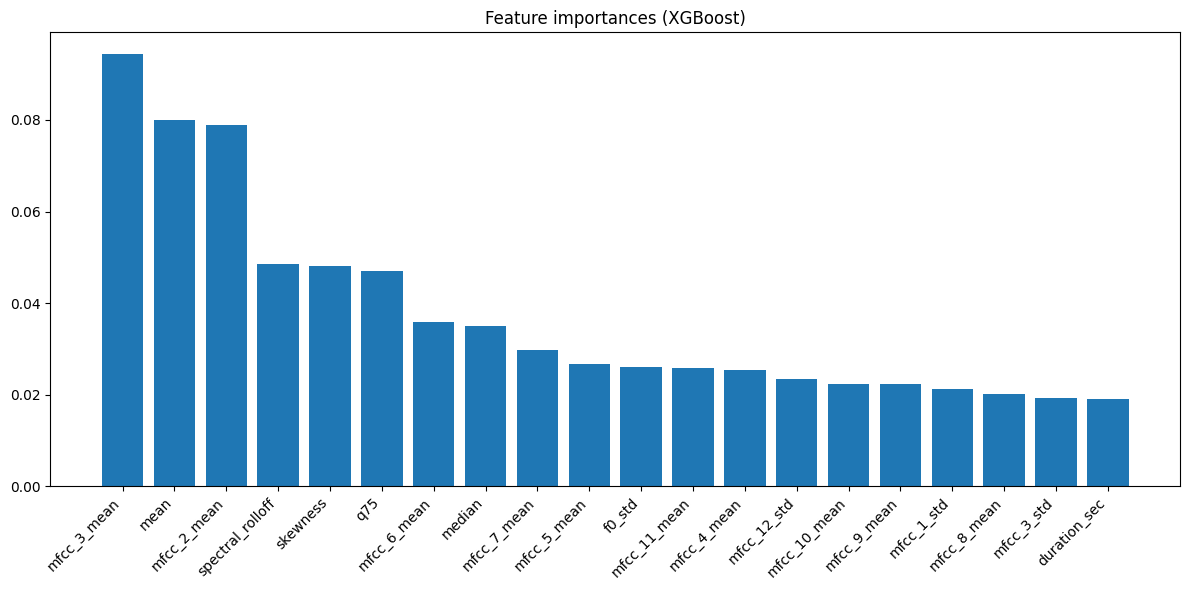

In [ ]:
for name in ['RandomForest', 'XGBoost']:
    if name in results:
        clf = results[name]['model'].best_estimator_
        importances = clf.feature_importances_
        idx = np.argsort(importances)[::-1][:20]
        plt.figure(figsize=(12, 6))
        plt.bar(np.array(all_features)[idx], importances[idx])
        plt.title(f'Feature importances ({name})')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# 5. Prétraitement SincNet : suppression des silences, normalisation, chunking

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
EMODB_ROOT = Path("/kaggle/input/berlin-database-of-emotional-speech-emodb/wav")
EMOTION_MAP = {
    "W": ("anger", 0),
    "L": ("boredom", 1),
    "E": ("disgust", 2),
    "A": ("fear", 3),
    "F": ("happiness", 4),
    "T": ("sadness", 5),
    "N": ("neutral", 6),
}

N_CLASSES = len(EMOTION_MAP)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

In [ ]:
class EmoDBDataset(Dataset):
    def __init__(self, items, wav_root, fs=16000,
                 cw_len=200, cw_shift=10,
                 audio_cache=None):
        
        self.items = items
        self.wav_root = wav_root
        self.audio_cache = audio_cache if audio_cache is not None else {}

        self.fs = fs
        self.wlen = int(fs * cw_len / 1000)
        self.wshift = int(fs * cw_shift / 1000)

        self.index = []
        self._prepare_chunks()

    def _load_audio(self, filename):
        if filename not in self.audio_cache:
            signal, sr = sf.read(self.wav_root / filename)
            assert sr == self.fs
            self.audio_cache[filename] = signal
        return self.audio_cache[filename]

    def _prepare_chunks(self):
        for item in self.items:
            signal = self._load_audio(item["filename"])
            length = len(signal)

            for beg in range(0, length - self.wlen, self.wshift):
                self.index.append((item, beg))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        item, beg = self.index[idx]
        signal = self._load_audio(item["filename"])

        chunk = signal[beg:beg + self.wlen]
        label = item["emotion_idx"]

        return (
            torch.tensor(chunk, dtype=torch.float32),
            torch.tensor(label, dtype=torch.long)
        )

In [ ]:
SPEAKERS = ['03', '08', '09', '10', '11', '12', '13', '14', '15', '16']
speaker_to_items = defaultdict(list)

for item in meta:
    speaker_to_items[item["speaker_id"]].append(item)

kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
speaker_ids = np.array(SPEAKERS)

In [ ]:
from dnn_models import SincNet, MLP

def build_model():
    cnn_options = {
        "cnn_N_filt": [80, 60, 60],
        "cnn_len_filt": [251, 5, 5],
        "cnn_max_pool_len": [3, 3, 3],
        "cnn_act": ["relu", "relu", "relu"],
        "cnn_drop": [0.0, 0.0, 0.0],
        "cnn_use_laynorm": [True, True, True],
        "cnn_use_batchnorm": [False, False, False],
        "cnn_use_laynorm_inp": True,
        "cnn_use_batchnorm_inp": False,
        "input_dim": int(16000 * 0.2),
        "fs": 16000
    }

    dnn_options = {
        "input_dim": None,
        "fc_lay": [2048, 2048],
        "fc_drop": [0.5, 0.5],
        "fc_use_laynorm": [True, True],
        "fc_use_batchnorm": [False, False],
        "fc_use_laynorm_inp": False,
        "fc_use_batchnorm_inp": False,
        "fc_act": ["relu", "relu"]
    }

    cnn = SincNet(cnn_options)
    dnn_options["input_dim"] = cnn.out_dim
    dnn = MLP(dnn_options)
    classifier = nn.Linear(dnn_options["fc_lay"][-1], N_CLASSES)

    model = nn.Sequential(cnn, dnn, classifier)
    return model.to(device)

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    correct, total = 0, 0
    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / total

In [ ]:
from collections import defaultdict

def eval_utterance_level(model, items, wav_root,
                         fs=16000, cw_len=200, cw_shift=10,
                         batch_size=128):
    """
    Returns utterance-level accuracy using mean posterior voting
    """
    model.eval()

    wlen = int(fs * cw_len / 1000)
    wshift = int(fs * cw_shift / 1000)

    correct = 0
    total = 0

    with torch.no_grad():
        for item in items:
            signal, sr = sf.read(wav_root / item["filename"])
            assert sr == fs

            chunks = []
            for beg in range(0, len(signal) - wlen, wshift):
                chunks.append(signal[beg:beg + wlen])

            if len(chunks) == 0:
                continue

            chunks = torch.tensor(chunks, dtype=torch.float32).to(device)

            # batch inference
            probs_sum = torch.zeros(N_CLASSES, device=device)

            for i in range(0, len(chunks), batch_size):
                out = model(chunks[i:i + batch_size])
                probs = torch.softmax(out, dim=1)
                probs_sum += probs.sum(dim=0)

            probs_mean = probs_sum / len(chunks)
            pred = probs_mean.argmax().item()

            if pred == item["emotion_idx"]:
                correct += 1
            total += 1

    return correct / total

In [ ]:
fold_accuracies = []
audio_cache = {}

for fold, (train_idx, test_idx) in enumerate(kf.split(speaker_ids), 1):
    train_speakers = speaker_ids[train_idx]
    test_speakers  = speaker_ids[test_idx]

    train_items = sum([speaker_to_items[s] for s in train_speakers], [])
    test_items  = sum([speaker_to_items[s] for s in test_speakers], [])

    train_set = EmoDBDataset(
        train_items,
        EMODB_ROOT,
        audio_cache=audio_cache
    )
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)
    test_set = EmoDBDataset(
        test_items,
        EMODB_ROOT,
        audio_cache=audio_cache
    )
    model = build_model()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print(f"\n=== Fold {fold} ===")
    print(f"\n=== Fold {fold} | Train speakers: {train_speakers} | Test speakers: {test_speakers} ===")
    for epoch in range(1, 31):
        tr_acc = train_epoch(model, train_loader, optimizer, criterion)

    te_acc = eval_utterance_level(model, test_items, EMODB_ROOT)
    print(f"Utterance-level accuracy: {te_acc:.3f}")

    fold_accuracies.append(te_acc)


=== Fold 1 ===

=== Fold 1 | Train speakers: ['03' '08' '09' '10' '11' '12' '13' '15' '16'] | Test speakers: ['14'] ===


100%|██████████| 939/939 [00:45<00:00, 20.45it/s]
/tmp/ipykernel_55/3049649888.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  chunks = torch.tensor(chunks, dtype=torch.float32).to(device)


Utterance-level accuracy: 0.855

=== Fold 2 ===

=== Fold 2 | Train speakers: ['03' '08' '10' '11' '12' '13' '14' '15' '16'] | Test speakers: ['09'] ===


100%|██████████| 995/995 [00:48<00:00, 20.36it/s]


Utterance-level accuracy: 0.581

=== Fold 3 ===

=== Fold 3 | Train speakers: ['03' '08' '09' '10' '11' '12' '13' '14' '15'] | Test speakers: ['16'] ===


100%|██████████| 921/921 [00:45<00:00, 20.17it/s]


Utterance-level accuracy: 0.620

=== Fold 4 ===

=== Fold 4 | Train speakers: ['03' '09' '10' '11' '12' '13' '14' '15' '16'] | Test speakers: ['08'] ===


100%|██████████| 950/950 [00:46<00:00, 20.34it/s]


Utterance-level accuracy: 0.724

=== Fold 5 ===

=== Fold 5 | Train speakers: ['08' '09' '10' '11' '12' '13' '14' '15' '16'] | Test speakers: ['03'] ===


100%|██████████| 986/986 [00:48<00:00, 20.31it/s]


Utterance-level accuracy: 0.837

=== Fold 6 ===

=== Fold 6 | Train speakers: ['03' '08' '09' '10' '11' '12' '13' '14' '16'] | Test speakers: ['15'] ===


100%|██████████| 979/979 [00:48<00:00, 20.29it/s]


Utterance-level accuracy: 0.571

=== Fold 7 ===

=== Fold 7 | Train speakers: ['03' '08' '09' '10' '12' '13' '14' '15' '16'] | Test speakers: ['11'] ===


100%|██████████| 964/964 [00:47<00:00, 20.38it/s]


Utterance-level accuracy: 0.564

=== Fold 8 ===

=== Fold 8 | Train speakers: ['03' '08' '09' '10' '11' '13' '14' '15' '16'] | Test speakers: ['12'] ===


100%|██████████| 1007/1007 [00:49<00:00, 20.33it/s]


Utterance-level accuracy: 0.600

=== Fold 9 ===

=== Fold 9 | Train speakers: ['03' '08' '09' '10' '11' '12' '14' '15' '16'] | Test speakers: ['13'] ===


100%|██████████| 964/964 [00:47<00:00, 20.10it/s]


Utterance-level accuracy: 0.672

=== Fold 10 ===

=== Fold 10 | Train speakers: ['03' '08' '09' '11' '12' '13' '14' '15' '16'] | Test speakers: ['10'] ===


100%|██████████| 1014/1014 [00:50<00:00, 20.26it/s]


Utterance-level accuracy: 0.711


In [ ]:
sum(fold_accuracies)/len(fold_accuracies)

0.6734781145771906

On obtient une accuracy moyenne de 67 %. Cependant, on note que lorsqu'on utilise le locuteur 14 comme locuteur de test, on obitent alors 85 % de précision soit un gain de plus de 8 % par rapport aux modèles baseline.

Cette différence entre les différents locuteurs de test souligne l'importance d'utiliser une cross validation à locuteurs indépendants. On note aussi que l'écart-type des accuracy obtenues est de plus de 0.1, c'est à dire 10% d'accuracy.